In [1]:
# import necessary modules
import warnings
warnings.filterwarnings('ignore')
import time 
import pandas as pd
import numpy as np
import sys

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression 
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# settings to display all columns
pd.set_option("display.max_columns", None)

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

VERSION = 1
VAL_SIZE = 0.20   # 20%

Python       : 3.8.10 (default, May 19 2021, 11:01:55) 
Numpy        : 1.19.1


In [2]:
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
data = pd.read_csv('data_train_0509.csv')
data.sample()

,bodyType,brand,color,fuelType,numberOfDoors,productionDate,vehicleTransmission,enginePower,mileage,drivetrain,driveSide,ownersCount,tcp,rarity,price,model,vendor,train,sell_id,transmission,price_log,RUB_USD_rate,price_usd,km_per_year,carNovelty,prodDate_3Y,prodDate_5Y,ownershipTimeIsNull,descriptionIsNull,newCar,brandPopular,modelPopular,colorPopular,description_words_count
71282,0,34,13,0,4,2020,3,5.01728,0.0,1,0,0,1,6,2156200.0,1060,2,1,0,0,14.583858,75.2048,28671.042274,0.0,4,0,0,0,0,1,1,1,1,6.829794


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121502 entries, 0 to 121501
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   bodyType                 121502 non-null  int64  
 1   brand                    121502 non-null  int64  
 2   color                    121502 non-null  int64  
 3   fuelType                 121502 non-null  int64  
 4   numberOfDoors            121502 non-null  int64  
 5   productionDate           121502 non-null  int64  
 6   vehicleTransmission      121502 non-null  int64  
 7   enginePower              121502 non-null  float64
 8   mileage                  121502 non-null  float64
 9   drivetrain               121502 non-null  int64  
 10  driveSide                121502 non-null  int64  
 11  ownersCount              121502 non-null  int64  
 12  tcp                      121502 non-null  int64  
 13  rarity                   121502 non-null  int64  
 14  pric

**Обновим списки переменных**

In [ ]:
num_cols = ['productionDate', 'enginePower', 'mileage',
            'km_per_year', 'carNovelty']
bin_cols = ['driveSide', 'ownershipTimeIsNull', 'newCar',
            'transmission', 'tcp', 'prodDate_3Y', 'prodDate_5Y', 'descriptionIsNull']
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'drivetrain', 'model',
            'vendor', 'vehicleTransmission', 'numberOfDoors', 'ownersCount', 'rarity']
service_cols = ['train', 'sell_id', 'parsing_date', 'RUB_USD_rate']
target_col = ['price', 'price_usd', 'price_log']

In [ ]:
print(f'Всего переменных: {len(data.columns)}')
print(f'Из них:')
print(f'Чиcловых переменных: {len(num_cols)},\n {num_cols}')
print(f'Бинарных переменных: {len(bin_cols)},\n {bin_cols}')
print(f'Категориальных переменных: {len(cat_cols)},\n {cat_cols}')
print(f'Сервисных переменных: {len(service_cols)},\n {service_cols}')
print(f'Таргет: {len(target_col)},\n {target_col}')

### Значимость переменных F-тест

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

In [ ]:
fig, ax = plt.subplots(figsize=(18, 7))
df = data[data['train'] == 1]
imp_num = pd.Series(f_regression(df[num_cols + bin_cols + cat_cols], df['price'])[0], index=num_cols + bin_cols + cat_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh');

In [ ]:
# f_regression(df[num_cols + bin_cols + cat_cols], df['price'])[0]

**Вывод:** все признаки значимы, все оставляем

### Значимость не числовых переменных Взаимная информация

Для оценки значимости категориальных и бинарных переменных будем использовать функцию `mutual_info_regression` из библиотеки `sklearn`. 

In [ ]:
# для не числовых переменных
fig, ax = plt.subplots(figsize=(18, 7))
df = data[data['train'] == 1]
imp_cat = pd.Series(mutual_info_regression(df[bin_cols + cat_cols], df['price'],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

In [ ]:
# f_mutual_info_regression(df[bin_cols + cat_cols], df['price'])[0]

**Вывод:** Признак `rarity` оказался незначимым, пока ничего не удаляем

### Отбор признаков с помощью FeatureSelector

In [ ]:
# УСТАНОВКА FeatureSelector
!git clone https://github.com/WillKoehrsen/feature-selector.git
%cd feature-selector
!pip install -e .

# установка в colabe - !pip install feature_selector

In [ ]:
from feature_selector import FeatureSelector

In [ ]:
train = data.query('train == 1')[num_cols + bin_cols + cat_cols]
train_labels = data[data.train == 1]['price']
train.shape, train_labels.shape

In [ ]:
# Признаки - в train, метки - в train_labels
fs = FeatureSelector(data = train, labels = train_labels)

### пропущенные значения

In [ ]:
# пропущенные значения
fs.identify_missing(missing_threshold=0.1)

### признаки с единственным значением

In [ ]:
# признаки с единственным значением
fs.identify_single_unique()

### коллинеарные признаки

In [ ]:
# коллинеарные признаки
fs.identify_collinear(correlation_threshold=0.8)
correlated_features = fs.ops['collinear']
print(correlated_features)
fs.plot_collinear(plot_all=True)

In [ ]:
fs.record_collinear.head()

Получим доступ к списку функций с высокой взаимной корреляцией

In [ ]:
collinear_features = fs.ops['collinear']
collinear_features[:]

### признаки с нулевой важностью

In [ ]:
# признаки с нулевой важностью
fs.identify_zero_importance(task = 'regression', eval_metric = 'l1', 
                            early_stopping = False)

In [ ]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

In [ ]:
fs.data_all.head()

In [ ]:
fs.feature_importances.head(24)

In [ ]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 18)

Мы могли бы использовать эти результаты, чтобы выбрать только «n» наиболее важных функций. Например, если мы хотим составить 100 самых важных, мы можем сделать следующее.

In [ ]:
one_hundred_features = list(fs.feature_importances.loc[:99, 'feature'])
len(one_hundred_features)

Получим доступ к списку функций с нулевой важностью

In [ ]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features[:]

### признаки с низкой важностью

In [ ]:
# признаки с низкой важностью
fs.identify_low_importance(cumulative_importance = 0.99)

Необходимо удалить те функции с низкой важностью, которые не влияют на указанную кумулятивную важность. Они также доступны в словаре ops.

In [ ]:
low_importance_features = fs.ops['low_importance']
low_importance_features[:]

### удаление признаков

In [ ]:
train_no_low_importance = fs.remove(methods = ['low_importance'])

In [ ]:
data.drop(low_importance_features[:], axis=1, inplace=True)

Посмотрим еще раз на зависимость признаков между собой

In [ ]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.heatmap(data[data['train'] == 1].drop(service_cols, 1).corr().abs(
), vmin=0, vmax=1, annot=True, fmt='.2f', cmap='Greens');

**Выводы:**

Удалим `parsing_date`

In [7]:
#data.drop('parsing_date', axis=1, inplace=True)

KeyError: "['parsing_date'] not found in axis"

####   Выделим тестовую и тренировочную части

In [8]:
# price
X = data.query('train == 1').drop(
    ['train', 'price', 'price_log', 'price_usd', 'RUB_USD_rate'], axis=1)
X_sub = data.query('train == 0').drop(
    ['train', 'price', 'price_log', 'price_usd', 'RUB_USD_rate'], axis=1)

y = data[data.train == 1]['price']
# y_usd = data[data.train == 1]['price_usd']

# X.shape, X_sub.shape, y.shape, y_usd.shape
X.shape, X_sub.shape, y.shape

((86816, 29), (34686, 29), (86816,))

#### Train Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69452, 29), (17364, 29), (69452,), (17364,))

# 5. Model 1. Создадим "наивную" модель 

In [10]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

# Находим median по экземплярам mileage в трейне и размечаем тест
predict = X_test['mileage'].map(
    tmp_train.groupby('mileage')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")
# Точность наивной модели по метрике MAPE: 72.97%

Точность наивной модели по метрике MAPE: 72.97%


# 6. Model 2 : CatBoost

In [90]:
# для target 'price'
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True
                          )
model.fit(X_train, y_train,
          # cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )

model.save_model('catboost_single_model_baseline.model')

# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
# Точность модели по метрике MAPE: 15.42%

Точность модели по метрике MAPE: 15.42%


### Log Traget

In [95]:
cat_features_ids = [0, 1, 2, 3, 4, 6, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27]

In [96]:
# для target 'price'
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, np.log(y_train),
          cat_features=cat_features_ids,
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )

model.save_model('catboost_single_model_2_baseline.model')

predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")
# Точность модели по метрике MAPE: 12.62

# с удалением признаков на каггле не отправляла
# Точность модели по метрике MAPE: 12.66%

Точность модели по метрике MAPE: 12.56%


# 7. Model 3. Lazypredict

In [ ]:
# !pip install lazypredict

In [ ]:
# import lazypredict
# from lazypredict.Supervised import LazyRegressor
# from sklearn.utils import shuffle

In [ ]:
# mae = mean_absolute_error
# regr=LazyRegressor(verbose=0,predictions=True, custom_metric=mae)
# # fit and train the model 
# start_time_2=time.time()
# models, predictions=regr.fit(X_train, X_test, np.log(y_train), np.log(y_test))
# end_time_2=time.time()

In [ ]:
# models

**Вывод:** Используя **LazyRegressor** получили лучших 5 моделей для нашего набора данных:
- RandomForestRegressor
- XGBRegressor	
- ExtraTreesRegressor
- BaggingRegressor	
- HistGradientBoostingRegressor

В отдельности попробуем каждую из моделей, чтобы найти лучшую

## # Модель 1: RandomForestRegressor

In [ ]:
# # без логарифмирования целевой переменной
# rf = RandomForestRegressor(random_state = RANDOM_SEED)
# rf.fit(X_train, y_train)
# rf_pred = rf.predict(X_test)

# print(
#     f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, rf_pred))*100:0.2f}%")

# # с логарифмированием целевой переменной
# rf_log = RandomForestRegressor(random_state = RANDOM_SEED)
# rf_log.fit(X_train, np.log(y_train + 1))
# rf_log_pred = np.exp(rf_log.predict(X_test))

# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, rf_log_pred))*100:0.2f}%")
# # Точность модели по метрике MAPE без логтаргета: 15.08%
# # Точность модели по метрике MAPE с логтаргетом: 13.28%

In [ ]:
# random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
#                'max_features': ['auto', 'sqrt', 'log2'],
#                'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'bootstrap': [True, False]}

# rfr = RandomForestRegressor(random_state = RANDOM_SEED)
# rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
# # rf_random.fit(X_train, y_train)
# rf_random.fit(X_train, np.log(y_train))
# rf_random.best_params_
# # best_params_
# # {'bootstrap': True,
# #  'max_depth': None,
# #  'max_features': 'auto',
# #  'min_samples_leaf': 1,
# #  'min_samples_split': 2,
# #  'n_estimators': 300}
# # rf_random.best_estimator_ = RandomForestRegressor(n_estimators=300, random_state=42)

In [43]:
best_rfr = rf_random.best_estimator_

NameError: name 'rf_random' is not defined

In [44]:
#best_rfr = rf_random.best_estimator_
best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=300
                      , min_samples_split=2
                      , min_samples_leaf=1
                      , max_features='auto'
                      , max_depth=None
                      , bootstrap=True)

# best_rfr.fit(X_train, y_train)
best_rfr.fit(X_train, np.log(y_train))

# predict_rfr = best_rfr.predict(X_test)
predict_rfr = np.exp(best_rfr.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_rfr))*100:0.2f}%")
# Точность модели по метрике MAPE с логтаргетом: 13.25%
# на kaggle скор 11.9975 (21 место)

# с удалением признаков на каггл не отправляла
# Точность модели по метрике MAPE с логтаргетом: 13.24%

Точность модели по метрике MAPE с логтаргетом: 12.84%


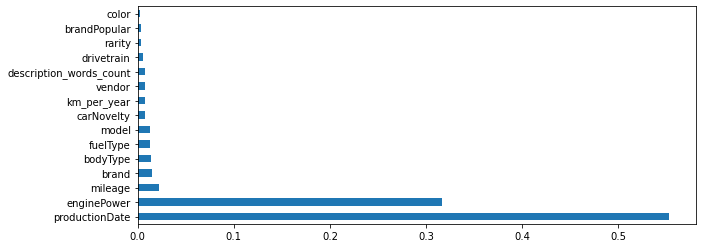

In [45]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,4)
feat_importances = pd.Series(best_rfr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

**Выводы:**

## # Модель 2: XGBRegressor

In [23]:
!pip install xgboost

In [24]:
import xgboost as xgb

In [66]:
# можно попробывать менять learning_rate (0.05, 0.03), max_depth (8,12,24,36)
# без логарифмирования целевой переменной
#xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
#                          learning_rate=0.05, max_depth=12, alpha=1,
#                          n_estimators=1000)
#xgb_reg.fit(X_train, y_train)
#print(
#    f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, xgb_reg.predict(X_test)))*100:0.2f}%")

# с логарифмированием целевой переменной
xgb_reg_log = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          alpha=1, n_estimators=1000)
xgb_reg_log.fit(X_train, np.log(y_train))

print(f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, np.exp(xgb_reg_log.predict(X_test))))*100:0.2f}%")

predict_submission = np.exp(xgb_reg_log.predict(X_sub))

# Точность модели по метрике MAPE без логтаргета: 14.22%
# Точность модели по метрике MAPE с логтаргетом: 12.22%

Точность модели по метрике MAPE с логтаргетом: 12.96%


In [29]:
# с логарифмированием целевой переменной
xgb_reg_log = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.03, max_depth=12, alpha=1,
                          n_estimators=1000)
xgb_reg_log.fit(X_train, np.log(y_train))

print(
    f"Точность модели по метрике MAPE с логтаргетом и learning_rate=0.03: {(mape(y_test, np.exp(xgb_reg_log.predict(X_test))))*100:0.2f}%")

predict_submission = np.exp(xgb_reg_log.predict(X_sub))

Точность модели по метрике MAPE с логтаргетом и learning_rate=0.03: 12.18%


Попробуем с логарифмом таргета разную глубину.

In [28]:
def xgb_reg_learn(depth):
    xgb_list = []
    for i in depth:
        xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                                   learning_rate=0.05, max_depth=i, alpha=1,
                                   n_estimators=1000)
        xgb_reg.fit(X_train, np.log(y_train))
        xgb_list.append(xgb_reg)
        print(
            f"Точность модели по метрике MAPE с логтаргетом и max_depth={i}: {(mape(y_test, np.exp(xgb_reg.predict(X_test))))*100:0.2f}%")
    return xgb_list


depth = [3, 5, 8, 12, 24, 36]
xgb_list = xgb_reg_learn(depth)

# Точность модели по метрике MAPE с логтаргетом и max_depth=3: 15.40%
# Точность модели по метрике MAPE с логтаргетом и max_depth=5: 13.37%
# Точность модели по метрике MAPE с логтаргетом и max_depth=8: 12.44%
# Точность модели по метрике MAPE с логтаргетом и max_depth=12: 12.47%
# Точность модели по метрике MAPE с логтаргетом и max_depth=24: 12.57%
# Точность модели по метрике MAPE с логтаргетом и max_depth=36: 12.60%
# на kaggle скор 11.47157 (17 место)

# с удаление признаков:
# Точность модели по метрике MAPE с логтаргетом и max_depth=3: 15.43%
# Точность модели по метрике MAPE с логтаргетом и max_depth=5: 13.30%
# Точность модели по метрике MAPE с логтаргетом и max_depth=8: 12.39%
# Точность модели по метрике MAPE с логтаргетом и max_depth=12: 12.47%
# Точность модели по метрике MAPE с логтаргетом и max_depth=24: 12.60%
# Точность модели по метрике MAPE с логтаргетом и max_depth=36: 12.61%
# на kaggle скор 12.4822 ( место)

Точность модели по метрике MAPE с логтаргетом и max_depth=3: 15.41%
Точность модели по метрике MAPE с логтаргетом и max_depth=5: 13.31%
Точность модели по метрике MAPE с логтаргетом и max_depth=8: 12.28%
Точность модели по метрике MAPE с логтаргетом и max_depth=12: 12.22%
Точность модели по метрике MAPE с логтаргетом и max_depth=24: 12.31%
Точность модели по метрике MAPE с логтаргетом и max_depth=36: 12.31%


Точность модели по метрике MAPE с логтаргетом и max_depth=3: 15.41%
Точность модели по метрике MAPE с логтаргетом и max_depth=5: 13.31%
Точность модели по метрике MAPE с логтаргетом и max_depth=8: 12.28%
Точность модели по метрике MAPE с логтаргетом и max_depth=12: 12.22%
Точность модели по метрике MAPE с логтаргетом и max_depth=24: 12.31%
Точность модели по метрике MAPE с логтаргетом и max_depth=36: 12.31%

In [30]:
best_xgb = xgb_list[3]
best_xgb

#alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
#             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
#             importance_type='gain', interaction_constraints='',
#             min_child_weight=1, missing=nan, monotone_constraints='()',
#             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
#             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
#             tree_method='exact', validate_parameters=1, verbosity=None

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
best_xgb.fit(X_train, np.log(y_train))

print(
    f"Точность модели best_xgb по метрике MAPE с логтаргетом: {(mape(y_test, np.exp(best_xgb.predict(X_test))))*100:0.2f}%")

predict_submission = np.exp(best_xgb.predict(X_sub))

Точность модели по метрике MAPE с логтаргетом и learning_rate=0.03: 12.22%


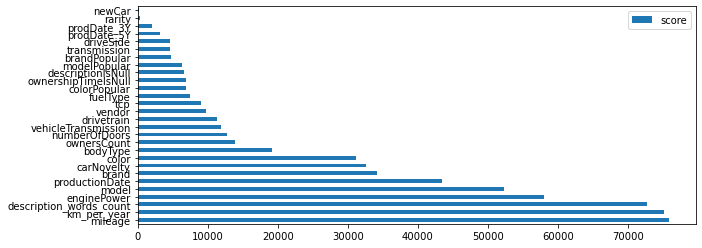

In [31]:
feature_important = best_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh');

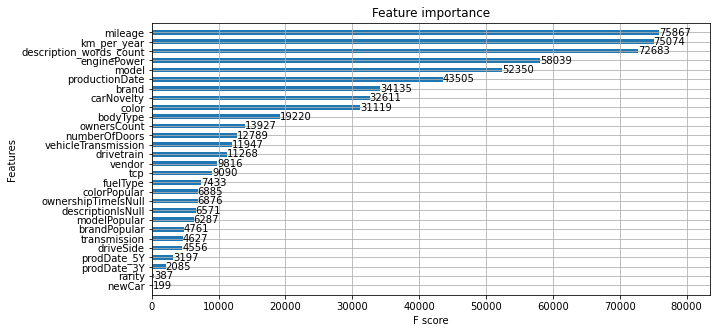

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
xgb.plot_importance(best_xgb, max_num_features=50, height=0.5, ax=ax)
plt.show()

## # Модель 3: ExtraTreesRegressor

In [ ]:
# # без логарифмирования целевой переменной
# etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
# etr.fit(X_train, y_train)
# etr_pred = etr.predict(X_test)

# print(
#     f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, etr_pred))*100:0.2f}%")

# # с логарифмированием целевой переменной
# etr_log = ExtraTreesRegressor(random_state = RANDOM_SEED)
# etr_log.fit(X_train, np.log(y_train + 1))
# etr_log_pred = np.exp(etr_log.predict(X_test))

# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, etr_log_pred))*100:0.2f}%")
# # Точность модели по метрике MAPE без логтаргета: 15.26%
# # Точность модели по метрике MAPE с логтаргетом: 13.65%

Запускаем дефолтную модель на логорифме цены.

In [111]:
etr = ExtraTreesRegressor(random_state = RANDOM_SEED)

# best_rfr.fit(X_train, y_train)
etr.fit(X_train, np.log(y_train))

# predict_rfr = best_rfr.predict(X_test)
etr_pred = np.exp(etr.predict(X_test))
#predict_submission = np.exp(etr.predict(X_sub))

print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, etr_pred))*100:0.2f}%")
# Точность модели по метрике MAPE с логтаргетом: 13.10%
# Точность модели по метрике MAPE с логтаргетом на Kaggle: 10.95491%

Точность модели по метрике MAPE с логтаргетом: 13.10%


In [100]:
#predict_submission = np.exp(best_etr.predict(X_sub))

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION+3}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.185703e+05
1,1100549428,8.757499e+05
2,1100658222,8.792430e+05
3,1100937408,6.965516e+05
4,1101037972,6.810040e+05
5,1100912634,8.295029e+05
6,1101228730,6.372938e+05
7,1100165896,4.159327e+05
8,1100768262,1.694547e+06
9,1101218501,8.747658e+05


Запускаем RandomizedSearchCV для ExtraTreesRegressor.

In [17]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=4)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
etr_random = RandomizedSearchCV(estimator = etr, 
                                param_distributions = random_grid, 
                                n_iter = 100, cv = 3, 
                                verbose=10, 
                                random_state=RANDOM_SEED, 
                                n_jobs = -1)

# rf_random.fit(X_train, y_train) 
etr_random.fit(X_train, np.log(y_train))

etr_random.best_params_
# # best_params_
# {'n_estimators': 300,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_features': 'auto',
#  'max_depth': None,
#  'bootstrap': True}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 24

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [18]:
etr_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

Запускаем ExtraTreesRegressor на гиперпараметрах, найденных через RandomizedSearchCV.

In [19]:
best_etr = ExtraTreesRegressor(random_state=RANDOM_SEED, 
                               n_estimators=300,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_features='auto',
                               max_depth=None,
                               bootstrap=True)

# best_rfr.fit(X_train, y_train)
best_etr.fit(X_train, np.log(y_train))

# predict_rfr = best_rfr.predict(X_test)
predict_etr = np.exp(best_etr.predict(X_test))
predict_submission = np.exp(best_etr.predict(X_sub))

print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_etr))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 13.10%
# Точность модели по метрике MAPE с логтаргетом на Kaggle: 10.95491%

# с удалением признаков:
# Точность модели по метрике MAPE с логтаргетом: 13.20%
# на kaggle скор 12.10545 ( место)

Точность модели по метрике MAPE с логтаргетом: 12.89%


<AxesSubplot:>

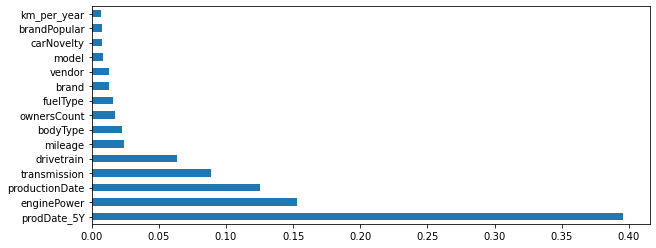

In [20]:
plt.rcParams['figure.figsize'] = (10,4)
feat_importances = pd.Series(best_etr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Модель 4: BaggingRegressor

In [46]:
# BaggingRegressor без 
bagg_rfr_d = BaggingRegressor(best_rfr, n_jobs=1, random_state=RANDOM_SEED)
bagg_rfr_d.fit(X_train, y_train)
predict_bagg_rfr_d = bagg_rfr_d.predict(X_test)
print(
    f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, predict_bagg_rfr_d))*100:0.2f}%")

# BaggingRegressor без настроек n_estimators=3
bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_rfr.fit(X_train, y_train)
predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_rfr))*100:0.2f}%")
# Точность модели по метрике MAPE без логтаргета: 15.18%
# Точность модели по метрике MAPE с логтаргетом: inf%

Точность модели по метрике MAPE без логтаргета: 15.02%
Точность модели по метрике MAPE с логтаргетом: inf%


## 4.1. Со случайным лесом

In [47]:
best_rfr

RandomForestRegressor(n_estimators=300, random_state=42)

In [48]:
bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_rfr.fit(X_train, y_train)
predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_rfr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: inf%


## 4.2. С XGBRegressor

In [36]:
best_xgb

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
bagg_xgb = BaggingRegressor(best_xgb, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_xgb.fit(X_train, np.log(y_train))
predict_bagg_xgb = np.exp(bagg_xgb.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_xgb))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 12.29%


In [53]:
bagg_xgb = BaggingRegressor(best_xgb, n_jobs=1, random_state=RANDOM_SEED)
bagg_xgb.fit(X_train, np.log(y_train))
predict_bagg_xgb = np.exp(bagg_xgb.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_xgb))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 12.18%


In [54]:
predict_submission = np.exp(bagg_xgb.predict(X_sub))

## 4.3. С ExtraTreesRegressor

In [56]:
etr = ExtraTreesRegressor(random_state = RANDOM_SEED)

# best_rfr.fit(X_train, y_train)
etr.fit(X_train, np.log(y_train))

ExtraTreesRegressor(random_state=42)

BaggingRegressor на дефолтных настройках.

In [57]:
bagg_etr = BaggingRegressor(etr, n_jobs=1, random_state=RANDOM_SEED)
bagg_etr.fit(X_train, np.log(y_train))
predict_bagg_etr = np.exp(bagg_etr.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_etr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 12.92%


BaggingRegressor n_estimators = 3 настройках.

In [60]:
bagg_etr = BaggingRegressor(etr, n_jobs=1, n_estimators = 3, random_state=RANDOM_SEED)
bagg_etr.fit(X_train, np.log(y_train))
predict_bagg_etr = np.exp(bagg_etr.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_etr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 13.12%


In [61]:
predict_submission = np.exp(bagg_etr.predict(X_sub))

## # Модель 5: HistGradientBoostingRegressor

In [68]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

Запускаем дефолтную модель на логорифме цены.

In [89]:
hgbr = HistGradientBoostingRegressor(random_state=RANDOM_SEED)

hgbr.fit(X_train, np.log(y_train))

hgbr_pred = np.exp(hgbr.predict(X_test))
predict_submission = np.exp(hgbr.predict(X_sub))

print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, hgbr_pred))*100:0.2f}%")
# Точность модели по метрике MAPE с логтаргетом: 15.28%
# Точность модели по метрике MAPE с логтаргетом на Kaggle: 16.10811%

Точность модели по метрике MAPE с логтаргетом: 15.28%


Запускаем RandomizedSearchCV для HistGradientBoostingRegressor.

In [84]:
random_grid = {'max_iter': [1000, 1200, 1500],
               'learning_rate': [0.1],
               'max_depth': [25, 50, 75],
               'l2_regularization': [1.5]}

hgbr = HistGradientBoostingRegressor(random_state=RANDOM_SEED)
hgbr_random = RandomizedSearchCV(estimator=hgbr,
                                 param_distributions=random_grid,
                                 n_iter=100, cv=3,
                                 verbose=10,
                                 random_state=RANDOM_SEED,
                                 n_jobs=-1)

hgbr_random.fit(X_train, np.log(y_train))

hgbr_random.best_params_
## {'max_iter': 1000,
## 'max_depth': 25,
## 'learning_rate': 0.1,
## 'l2_regularization': 1.5}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  1.7min remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.9min finished


{'max_iter': 1000,
 'max_depth': 25,
 'learning_rate': 0.1,
 'l2_regularization': 1.5}

Запускаем HistGradientBoostingRegressor на найденных параметрах.

In [87]:
hgbr = HistGradientBoostingRegressor(random_state=RANDOM_SEED, max_iter =1000,
                                     max_depth=25,
                                     learning_rate=0.1,
                                     l2_regularization=1.5)

hgbr.fit(X_train, np.log(y_train))

hgbr_pred = np.exp(hgbr.predict(X_test))
predict_submission = np.exp(hgbr.predict(X_sub))

print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, hgbr_pred))*100:0.2f}%")
# Точность модели по метрике MAPE с логтаргетом: 13.16%
# Точность модели по метрике MAPE с логтаргетом на Kaggle: 13.61184%

Точность модели по метрике MAPE с логтаргетом: 13.16%


# 8. Model 4. StackingRegressor

**Нужно выбрать 2 или 3 лучших модели для стекинга, определить какую модель лучше взять последней (решающей)** Внизу заготовка для стекинга

Выбирем для стека самые лучшие модели,  которые мы получили: Xgboosting, CatBoosting. Для обработки результатов возьмем линейную регрессию.
До этого пробовали брать за последнюю модель CatBoosting, но результаты оказались хуже.

Брать много сложных моделей не будем, так как даже при 2-3 моделях выполнение обучения идет более 30 минут.

In [ ]:
estimators=[('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED
                                                                ,n_estimators=800
                                                                ,min_samples_split=5
                                                                ,min_samples_leaf=4
                                                                ,max_features='sqrt'
                                                                ,max_depth=9)
                                        ,n_estimators=3
                                        ,n_jobs=1
                                        ,random_state=RANDOM_SEED))
            ,('xgb', xgb.XGBRegressor(objective='reg:squarederror'
                                      ,colsample_bytree=0.5
                                      ,learning_rate=0.05
                                      ,max_depth=12
                                      ,alpha=1
                                      ,n_estimators=1000))]

st_ensemble = StackingRegressor(estimators=estimators
                                ,final_estimator = CatBoostRegressor(iterations = 5000
                                                                     ,random_seed = RANDOM_SEED
                                                                     ,eval_metric='MAPE'
                                                                     ,custom_metric=['R2', 'MAE']
                                                                     ,silent=True
                                                                     ,learning_rate=0.13
                                                                     ,depth=12
                                                                     ,l2_leaf_reg=8
                                                                     ,random_strength=0.3))

# оцениваем точность    
st_ensemble.fit(X_train, np.log(y_train))
predict_ensemble = np.exp(st_ensemble.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble))*100:0.2f}%")

In [ ]:
estimators = [('xb',xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)),
              ('xb2',xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=500)),
              ('cb', CatBoostRegressor(iterations = 2000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         ))
            ]

st_ensemble = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

# оцениваем точность
st_ensemble.fit(X_train, np.log(y_train))
predict_ensemble = np.exp(st_ensemble.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble))*100:0.2f}%")

# Выбор модели

Во время исследования все модели запускались много раз. У нас были следующие параметры для проверки:
- логорифмировать или нет числовые признаки,
- Выбор обработки категориальных данных: Dumming, LabelEncoding
- Проводить или нет стандартизацию данных перед обучением

In [ ]:
X_sub.shape

In [99]:
#predict_submission = np.exp(best_etr.predict(X_sub))

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION+3}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.185703e+05
1,1100549428,8.757499e+05
2,1100658222,8.792430e+05
3,1100937408,6.965516e+05
4,1101037972,6.810040e+05
5,1100912634,8.295029e+05
6,1101228730,6.372938e+05
7,1100165896,4.159327e+05
8,1100768262,1.694547e+06
9,1101218501,8.747658e+05


#  Выводы:
    
1. парсинг
2. EDA - в

3. Lazypred - 

табличка - результаты 
